Using device: cuda
L shape: torch.Size([10000, 10000]), L device: cuda:0


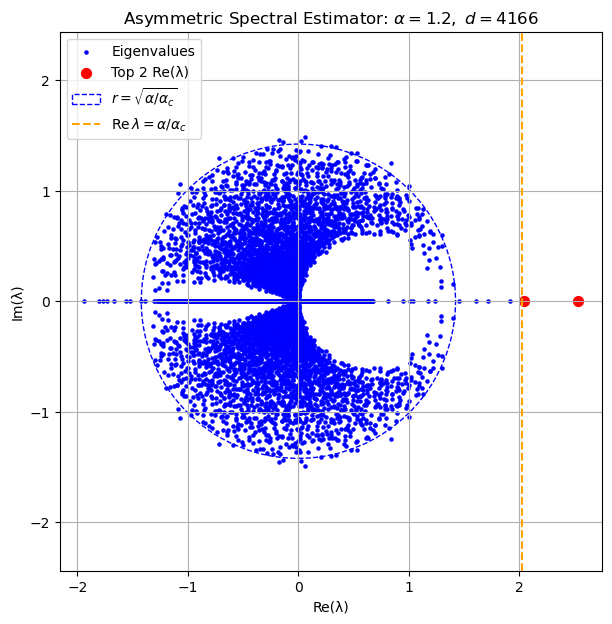

In [ ]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# Config
n = 5000          # samples
p = 2             # subspace dim
alpha = 1.2
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Input matrix X ∈ ℝ^{n×d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Signal subspace W* and observations Z = X W*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # link

# Preprocessing G(y) ∈ ℝ^{n×p×p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Asymmetric spectral matrix L ∈ ℝ^{np×np}
XXT = X @ X.T
XXT.fill_diagonal_(0.0)
A = XXT[:, :, None, None]
G_broadcast = G_y[None, :, :, :]
L_blocks = A * G_broadcast
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)
print(f"L shape: {L.shape}, L device: {L.device}")

# Eigenvalues
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# Plot spectrum
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# Theoretical radius and threshold
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c
circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


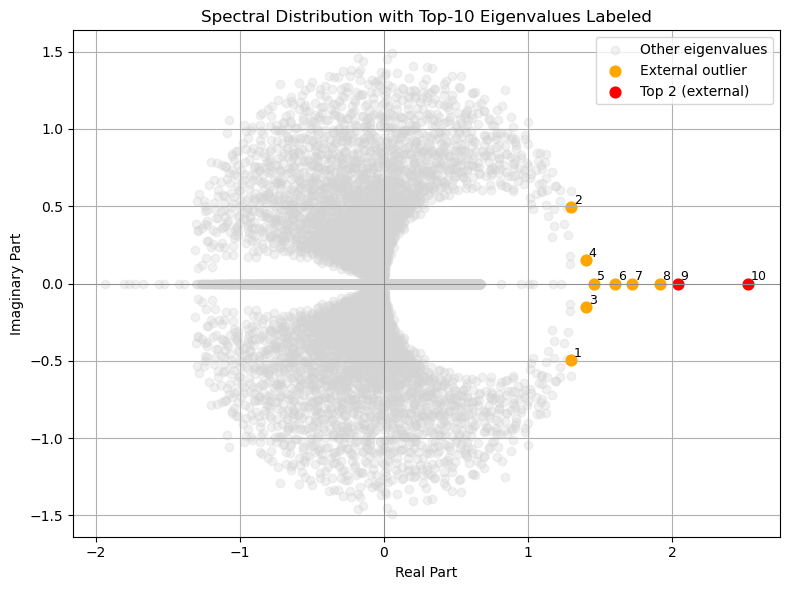

In [2]:
# Step 6: 绘制谱图（Complex Plane）

# ===== 设置阈值判别是否为 internal outlier =====
eig_mod = np.abs(eigvals_np)
eig_imag = eigvals_np.imag
bulk_radius = np.percentile(eig_mod, 90)  # 可调节 percentiles
delta = 0.05  # 容差
internal_mask = (eig_mod < bulk_radius - delta) & (np.abs(eig_imag) < 0.1)
external_mask = (eig_mod > bulk_radius + delta)

# ===== 标记前10个谱点中的类别 =====
top10_idx = np.argsort(eigvals_real)[-10:]
top10_vals = eigvals_np[top10_idx]

# ===== 绘制图形 =====
plt.figure(figsize=(8, 6))
plt.scatter(eigvals_np.real, eigvals_np.imag, color='lightgray', alpha=0.3, label="Other eigenvalues")

for i, idx in enumerate(top10_idx):
    val = eigvals_np[idx]
    color = "red" if idx in top2_idx else ("orange" if external_mask[idx] else "green")
    label = "Top 2 (external)" if idx in top2_idx else ("External outlier" if external_mask[idx] else "Internal drift")
    plt.scatter(val.real, val.imag, color=color, s=60, label=label if i == 0 or label not in plt.gca().get_legend_handles_labels()[1] else None)
    plt.text(val.real + 0.02, val.imag + 0.02, f"{i+1}", fontsize=9)

# ===== 绘制格式设置 =====
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("Spectral Distribution with Top-10 Eigenvalues Labeled")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


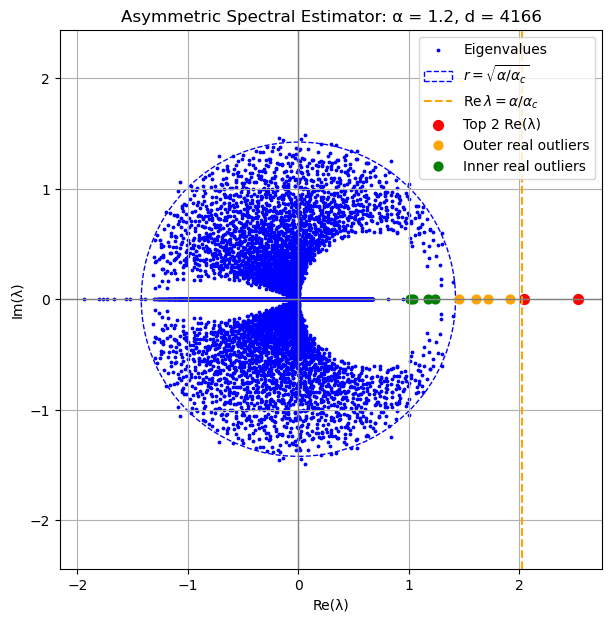

In [ ]:
# Spectral plot on the complex plane

# Thresholding to classify internal vs. external outliers
eig_mod = np.abs(eigvals_np)
eig_imag = eigvals_np.imag
bulk_radius = np.percentile(eig_mod, 90)  # can adjust percentile
delta = 0.05
internal_mask = (eig_mod < bulk_radius - delta) & (np.abs(eig_imag) < 0.1)
external_mask = (eig_mod > bulk_radius + delta)

# Top-10 eigenvalues
top10_idx = np.argsort(eigvals_real)[-10:]
top10_vals = eigvals_np[top10_idx]

# Plot spectral distribution
plt.figure(figsize=(8, 6))
plt.scatter(eigvals_np.real, eigvals_np.imag, color='lightgray', alpha=0.3, label="Other eigenvalues")

for i, idx in enumerate(top10_idx):
    val = eigvals_np[idx]
    color = "red" if idx in top2_idx else ("orange" if external_mask[idx] else "green")
    label = "Top 2 (external)" if idx in top2_idx else ("External outlier" if external_mask[idx] else "Internal drift")
    plt.scatter(val.real, val.imag, color=color, s=60,
                label=label if i == 0 or label not in plt.gca().get_legend_handles_labels()[1] else None)
    plt.text(val.real + 0.02, val.imag + 0.02, f"{i+1}", fontsize=9)

# Formatting
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("Spectral Distribution with Top-10 Eigenvalues Labeled")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


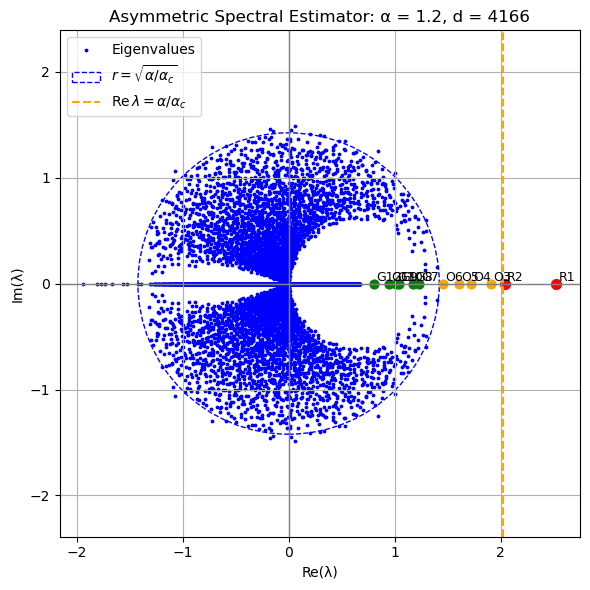

In [12]:
# 阈值定义
R = np.sqrt(alpha / alpha_c)        # 蓝色圆圈半径
thresh_ext = alpha / alpha_c        # 橙色虚线位置

# 筛选实数特征值（Im≈0）
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# 红色：前两个最大Re(λ)
red_vals = eigvals_real_only[np.argsort(real_parts)[-2:]]

# 橙色：在 [R, thresh_ext] 之间的点
orange_vals = []
green_candidates = []
for val in eigvals_real_only:
    if R < val.real < thresh_ext:
        orange_vals.append(val)
    elif val.real < R:
        green_candidates.append(val)

# 绿色：取前6个最靠近R的内部实轴点
green_vals = sorted(green_candidates, key=lambda z: -z.real)[:6]

# 绘图
plt.figure(figsize=(6, 6))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

# 圆和虚线
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# 绘制红色
for i, val in enumerate(sorted(red_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="red", s=50)
    plt.text(val.real+0.02, val.imag+0.02, f"R{i+1}", fontsize=9)

# 绘制橙色
for i, val in enumerate(sorted(orange_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="orange", s=40)
    plt.text(val.real+0.02, val.imag+0.02, f"O{i+3}", fontsize=9)

# 绘制绿色
for i, val in enumerate(sorted(green_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="green", s=40)
    plt.text(val.real+0.02, val.imag+0.02, f"G{i+7}", fontsize=9)

# 图设置
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}")
plt.legend(loc='upper left')
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


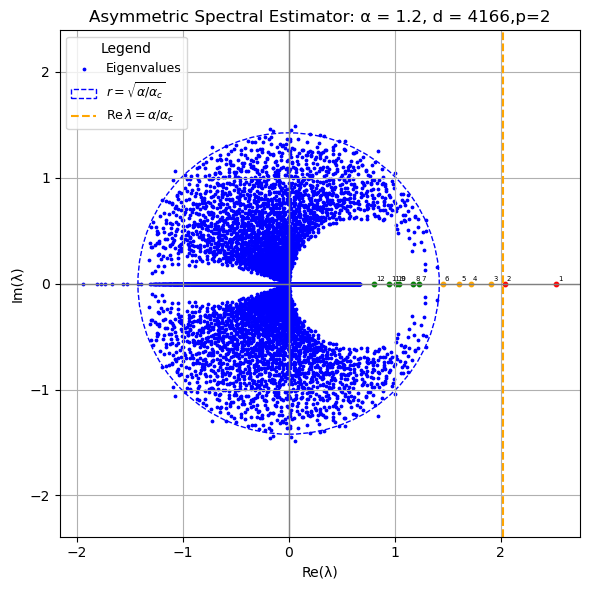

In [ ]:
# Thresholds
R = np.sqrt(alpha / alpha_c)          # Radius of spectral bulk
thresh_ext = alpha / alpha_c          # External threshold

# Select real-valued eigenvalues (Im ≈ 0)
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Red: top-2 eigenvalues with largest Re(λ)
red_vals = eigvals_real_only[np.argsort(real_parts)[-2:]]

# Orange: positive outliers in [R, thresh_ext]
orange_vals = []
green_candidates = []
for val in eigvals_real_only:
    if R < val.real < thresh_ext:
        orange_vals.append(val)
    elif val.real < R:
        green_candidates.append(val)

# Green: top-6 internal eigenvalues closest to R
green_vals = sorted(green_candidates, key=lambda z: -z.real)[:6]

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

# Bulk radius and threshold line
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False,
                    label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--",
            label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# Red points
for i, val in enumerate(sorted(red_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="red", s=50)
    plt.text(val.real + 0.02, val.imag + 0.02, f"R{i+1}", fontsize=9)

# Orange points
for i, val in enumerate(sorted(orange_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="orange", s=40)
    plt.text(val.real + 0.02, val.imag + 0.02, f"O{i+3}", fontsize=9)

# Green points
for i, val in enumerate(sorted(green_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="green", s=40)
    plt.text(val.real + 0.02, val.imag + 0.02, f"G{i+7}", fontsize=9)

# Axes and formatting
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}")
plt.legend(loc='upper left')
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


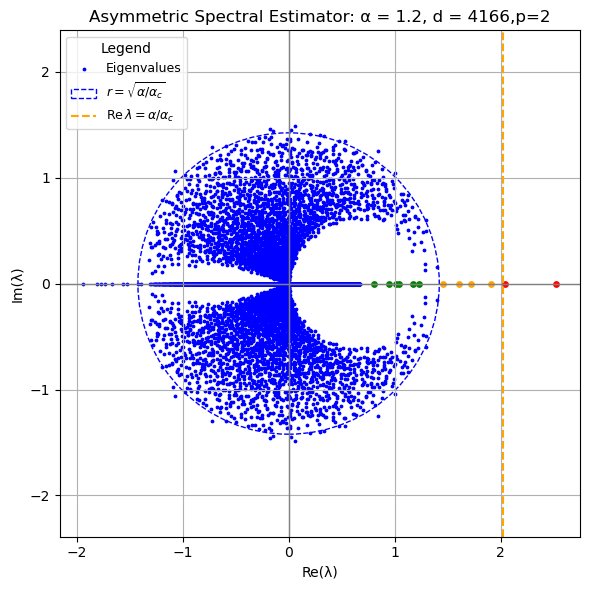

In [ ]:
# Thresholds
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c

# Select real eigenvalues
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Red: top-2 Re(λ)
red_vals = eigvals_real_only[np.argsort(real_parts)[-2:]]

# Orange: outliers in [R, thresh_ext]
orange_vals = []
green_candidates = []
for val in eigvals_real_only:
    if R < val.real < thresh_ext:
        orange_vals.append(val)
    elif val.real < R:
        green_candidates.append(val)

# Green: top-6 internal real eigenvalues
green_vals = sorted(green_candidates, key=lambda z: -z.real)[:6]

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="lightgray", s=3, alpha=0.4, label="Other Eigenvalues")

# Bulk radius + threshold line
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False,
                    label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--",
            label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# Red: top-2 outliers
plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals],
            color="red", s=20, label="Top-2 Outliers")

# Orange: external outliers
if orange_vals:
    plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals],
                color="orange", s=20, label="External Outliers")

# Green: internal signal eigenvalues
if green_vals:
    plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals],
                color="green", s=20, label="Internal Signal Eigenvalues")

# Axis and formatting
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator\nα = {alpha}, d = {d}, p = {p}")

# Legend
plt.legend(loc='upper left', fontsize=9, title="Legend", title_fontsize=10)
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()
